<a href="https://colab.research.google.com/github/brucewayneee1/ML-echo/blob/master/ML_%E1%BA%B9cho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import cv2
import numpy as np
import matplotlib.pyplot as plt


import torchvision
from torchvision import models,transforms
from torchvision.datasets import ImageFolder

from collections import namedtuple

from sklearn.metrics import classification_report

In [4]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else: print("Using CPU")

Using CPU


In [5]:
!git clone https://github.com/brucewayneee1/ML-echo

Cloning into 'ML-echo'...
remote: Enumerating objects: 8340, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 8340 (delta 2), reused 12 (delta 2), pack-reused 8328
Receiving objects: 100% (8340/8340), 488.03 MiB | 33.08 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (8326/8326), done.


In [6]:
TrainTest = namedtuple('TrainTest', ['train', 'test'])

def get_classes():
  classes = ['2C', '3C', '4C']
  return classes

def prepare_data():
  transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),                                
    transforms.ToTensor(),
  ])
  transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
  ])
  trainset = torchvision.datasets.ImageFolder(root="/content/ML-echo/DATA_CHAMBER_2021/train", transform=transform_train)
  testset = torchvision.datasets.ImageFolder(root="/content/ML-echo/DATA_CHAMBER_2021/test", transform=transform_test)
  return TrainTest(train=trainset, test=testset)

def prepare_loader(datasets):
  batch = 32
  worker = 4
  trainloader = DataLoader(dataset=datasets.train, batch_size=batch, shuffle=True, num_workers=worker)
  testloader = DataLoader(dataset=datasets.test, batch_size=batch, shuffle=False, num_workers=worker)
  #get a batch
  inputs, classes = next(iter(trainloader))
  show_databatch(inputs, classes)
  return TrainTest(train=trainloader, test=testloader)

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    class_names = prepare_data().train.classes
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


In [8]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  model.train()
  running_loss = 0.0
  reporting_steps = 40
  step = 0
  for images, labels in loader:
    step += 1
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = loss_func(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if step % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} step {step} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0

def test_epoch(epoch, model, loader, device):
  ytrue = []
  ypred = []
  with torch.no_grad():
    model.eval()
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      ytrue += list(labels.cpu().numpy())
      ypred += list(predicted.cpu().numpy())

  return ypred, ytrue

In [24]:
def main(model='vgg16'):
  classes = get_classes()
  datasets = prepare_data()
  loaders = prepare_loader(datasets)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Num Images in train set:", len(datasets.train))
  print("Num Images in test set:", len(datasets.test))
  print("Num batch in train set: ", len(loaders.train))
  print("class: ", datasets.train.class_to_idx)
  print("image size: ", datasets.train[0][0].shape)
  print("model:",model)
  print("device:", device)

  if model == 'vgg16':
    PATH='./vgg16.pth'  
    model = model = torchvision.models.vgg16()
    model.classifier[6] = nn.Linear(in_features=4096, out_features=3)
  elif model == 'vgg19':
    PATH='./vgg19.pth'
    model = torchvision.models.vgg16()
    model.classifier[6] = nn.Linear(in_features=4096, out_features=3)
  elif model == 'resnet50':
    PATH='./resnet50.pth'
    model = torchvision.models.resnet50(pretrained=False, progress=False)
    model.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True)
  elif model == 'densenet121':
    PATH='./densenet121.pth'
    model = torchvision.models.densenet121(pretrained=False)
    model.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=class_out, bias=True) 
  else:
    PATH='./resnet18.pth'
    model = models.resnet18()
    model.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 

  
  model.to(device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  accuracies = []
  for epoch in range(10):
    print("---------------------------------------------------------------")
    print(f"\nEpoch {epoch} report: ")
    train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ypred_test, ytrue_test = test_epoch(epoch, model, loaders.test, device)
    print("Test report: \n", classification_report(ytrue_test, ypred_test, target_names=classes))

  return model

In [ ]:
result_VGG16 = main(model='vgg16')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Num Images in train set: 6717
Num Images in test set: 1607
Num batch in train set:  210
class:  {'2C': 0, '3C': 1, '4C': 2}
image size:  torch.Size([3, 224, 224])
device: cuda
model: vgg16
---------------------------------------------------------------

Epoch 0 report: 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 step 39 ave_loss 1.0629
Epoch 0 step 79 ave_loss 1.0826
Epoch 0 step 119 ave_loss 1.0644
Epoch 0 step 159 ave_loss 0.9884
Epoch 0 step 199 ave_loss 0.8998
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.33      0.47       409
          3C       0.38      0.17      0.24       367
          4C       0.64      0.97      0.77       831

    accuracy                           0.63      1607
   macro avg       0.60      0.49      0.49      1607
weighted avg       0.61      0.63      0.57      1607

---------------------------------------------------------------

Epoch 1 report: 
Epoch 1 step 39 ave_loss 0.8032
Epoch 1 step 79 ave_loss 0.6670
Epoch 1 step 119 ave_loss 0.4903
Epoch 1 step 159 ave_loss 0.4230
Epoch 1 step 199 ave_loss 0.2872
Test report: 
               precision    recall  f1-score   support

          2C       0.69      0.94      0.80       409
          3C       0.59      0.62      0.61       367
          4C      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


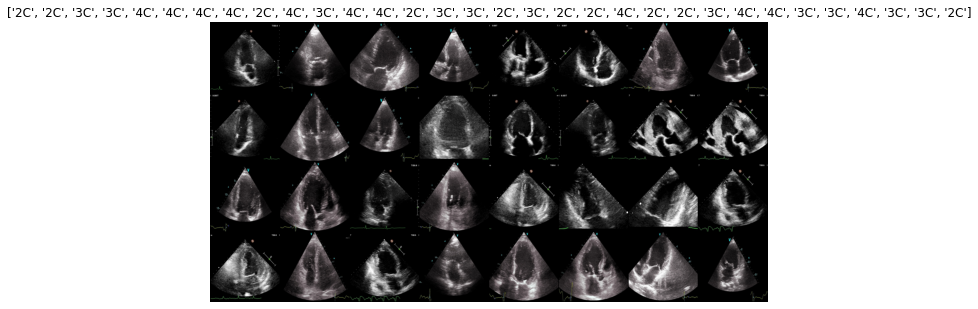

Num Images in train set: 6717
Num Images in test set: 1607
Num batch in train set:  210
class:  {'2C': 0, '3C': 1, '4C': 2}
image size:  torch.Size([3, 224, 224])
device: cuda
---------------------------------------------------------------

Epoch 0 report: 
Epoch 0 step 39 ave_loss 1.0682
Epoch 0 step 79 ave_loss 1.0955
Epoch 0 step 119 ave_loss 1.0831
Epoch 0 step 159 ave_loss 1.0875
Epoch 0 step 199 ave_loss 1.0682
Test report: 
               precision    recall  f1-score   support

          2C       0.27      1.00      0.43       409
          3C       0.00      0.00      0.00       367
          4C       1.00      0.12      0.21       831

    accuracy                           0.32      1607
   macro avg       0.42      0.37      0.21      1607
weighted avg       0.59      0.32      0.22      1607

---------------------------------------------------------------

Epoch 1 report: 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 1 step 39 ave_loss 1.0230
Epoch 1 step 79 ave_loss 1.0060
Epoch 1 step 119 ave_loss 0.8581
Epoch 1 step 159 ave_loss 0.8202
Epoch 1 step 199 ave_loss 0.5805
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.70      0.71       409
          3C       0.47      0.78      0.59       367
          4C       0.97      0.69      0.81       831

    accuracy                           0.72      1607
   macro avg       0.72      0.73      0.70      1607
weighted avg       0.79      0.72      0.73      1607

---------------------------------------------------------------

Epoch 2 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 39 ave_loss 0.4323
Epoch 2 step 79 ave_loss 0.4579
Epoch 2 step 119 ave_loss 0.3747
Epoch 2 step 159 ave_loss 0.3379
Epoch 2 step 199 ave_loss 0.2150
Test report: 
               precision    recall  f1-score   support

          2C       0.80      0.75      0.77       409
          3C       0.59      0.83      0.69       367
          4C       0.89      0.75      0.81       831

    accuracy                           0.77      1607
   macro avg       0.76      0.78      0.76      1607
weighted avg       0.80      0.77      0.78      1607

---------------------------------------------------------------

Epoch 3 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 39 ave_loss 0.1157
Epoch 3 step 79 ave_loss 0.1159
Epoch 3 step 119 ave_loss 0.1485
Epoch 3 step 159 ave_loss 0.1365
Epoch 3 step 199 ave_loss 0.0902
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.84      0.85       409
          3C       0.68      0.72      0.70       367
          4C       0.86      0.85      0.85       831

    accuracy                           0.82      1607
   macro avg       0.80      0.80      0.80      1607
weighted avg       0.82      0.82      0.82      1607

---------------------------------------------------------------

Epoch 4 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 39 ave_loss 0.0616
Epoch 4 step 79 ave_loss 0.0456
Epoch 4 step 119 ave_loss 0.1055
Epoch 4 step 159 ave_loss 0.0674
Epoch 4 step 199 ave_loss 0.0898
Test report: 
               precision    recall  f1-score   support

          2C       0.53      0.90      0.67       409
          3C       0.52      0.72      0.61       367
          4C       0.91      0.44      0.59       831

    accuracy                           0.62      1607
   macro avg       0.65      0.69      0.62      1607
weighted avg       0.72      0.62      0.61      1607

---------------------------------------------------------------

Epoch 5 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 39 ave_loss 0.0907
Epoch 5 step 79 ave_loss 0.0757
Epoch 5 step 119 ave_loss 0.0389
Epoch 5 step 159 ave_loss 0.0146
Epoch 5 step 199 ave_loss 0.0483
Test report: 
               precision    recall  f1-score   support

          2C       0.69      0.91      0.79       409
          3C       0.58      0.84      0.69       367
          4C       0.96      0.63      0.76       831

    accuracy                           0.75      1607
   macro avg       0.75      0.79      0.74      1607
weighted avg       0.81      0.75      0.75      1607

---------------------------------------------------------------

Epoch 6 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 39 ave_loss 0.0082
Epoch 6 step 79 ave_loss 0.0020
Epoch 6 step 119 ave_loss 0.0327
Epoch 6 step 159 ave_loss 0.0113
Epoch 6 step 199 ave_loss 0.0043
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.88      0.85       409
          3C       0.69      0.81      0.75       367
          4C       0.91      0.81      0.86       831

    accuracy                           0.83      1607
   macro avg       0.81      0.83      0.82      1607
weighted avg       0.84      0.83      0.83      1607

---------------------------------------------------------------

Epoch 7 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 39 ave_loss 0.0029
Epoch 7 step 79 ave_loss 0.0060
Epoch 7 step 119 ave_loss 0.0055
Epoch 7 step 159 ave_loss 0.0180
Epoch 7 step 199 ave_loss 0.0077
Test report: 
               precision    recall  f1-score   support

          2C       0.71      0.95      0.82       409
          3C       0.63      0.76      0.69       367
          4C       0.89      0.66      0.76       831

    accuracy                           0.76      1607
   macro avg       0.74      0.79      0.75      1607
weighted avg       0.78      0.76      0.76      1607

---------------------------------------------------------------

Epoch 8 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 step 39 ave_loss 0.0017
Epoch 8 step 79 ave_loss 0.0151
Epoch 8 step 119 ave_loss 0.0031
Epoch 8 step 159 ave_loss 0.0012
Epoch 8 step 199 ave_loss 0.0028
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.88      0.83       409
          3C       0.79      0.72      0.75       367
          4C       0.86      0.85      0.86       831

    accuracy                           0.83      1607
   macro avg       0.82      0.82      0.81      1607
weighted avg       0.83      0.83      0.83      1607

---------------------------------------------------------------

Epoch 9 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 step 39 ave_loss 0.0111
Epoch 9 step 79 ave_loss 0.0014
Epoch 9 step 119 ave_loss 0.0256
Epoch 9 step 159 ave_loss 0.0144
Epoch 9 step 199 ave_loss 0.0075
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.92      0.85       409
          3C       0.62      0.80      0.70       367
          4C       0.91      0.72      0.80       831

    accuracy                           0.79      1607
   macro avg       0.77      0.81      0.78      1607
weighted avg       0.81      0.79      0.79      1607



In [10]:
result_VGG19 = main(model='vgg19')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


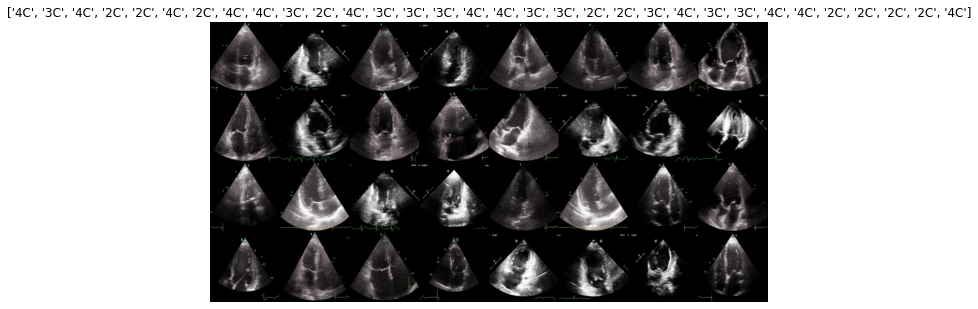

Num Images in train set: 6717
Num Images in test set: 1607
Num batch in train set:  210
class:  {'2C': 0, '3C': 1, '4C': 2}
image size:  torch.Size([3, 224, 224])
model: resnet50
device: cuda
---------------------------------------------------------------

Epoch 0 report: 
Epoch 0 step 39 ave_loss 3.0054
Epoch 0 step 79 ave_loss 1.4937
Epoch 0 step 119 ave_loss 1.4465
Epoch 0 step 159 ave_loss 1.3007
Epoch 0 step 199 ave_loss 1.1038
Test report: 
               precision    recall  f1-score   support

          2C       0.31      0.97      0.48       409
          3C       0.20      0.19      0.19       367
          4C       0.00      0.00      0.00       831

    accuracy                           0.29      1607
   macro avg       0.17      0.38      0.22      1607
weighted avg       0.12      0.29      0.16      1607

---------------------------------------------------------------

Epoch 1 report: 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 1 step 39 ave_loss 0.9788
Epoch 1 step 79 ave_loss 0.8723
Epoch 1 step 119 ave_loss 0.7568
Epoch 1 step 159 ave_loss 0.6503
Epoch 1 step 199 ave_loss 0.6533
Test report: 
               precision    recall  f1-score   support

          2C       0.43      0.82      0.56       409
          3C       0.33      0.40      0.36       367
          4C       0.93      0.44      0.60       831

    accuracy                           0.52      1607
   macro avg       0.56      0.55      0.51      1607
weighted avg       0.67      0.52      0.53      1607

---------------------------------------------------------------

Epoch 2 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 39 ave_loss 0.4025
Epoch 2 step 79 ave_loss 0.3301
Epoch 2 step 119 ave_loss 0.2472
Epoch 2 step 159 ave_loss 0.2445
Epoch 2 step 199 ave_loss 0.2606
Test report: 
               precision    recall  f1-score   support

          2C       0.68      0.38      0.49       409
          3C       0.34      0.89      0.50       367
          4C       0.98      0.49      0.65       831

    accuracy                           0.56      1607
   macro avg       0.67      0.59      0.55      1607
weighted avg       0.76      0.56      0.58      1607

---------------------------------------------------------------

Epoch 3 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 39 ave_loss 0.2862
Epoch 3 step 79 ave_loss 0.2195
Epoch 3 step 119 ave_loss 0.1509
Epoch 3 step 159 ave_loss 0.0867
Epoch 3 step 199 ave_loss 0.0817
Test report: 
               precision    recall  f1-score   support

          2C       0.52      0.74      0.61       409
          3C       0.69      0.74      0.71       367
          4C       0.92      0.70      0.79       831

    accuracy                           0.72      1607
   macro avg       0.71      0.73      0.71      1607
weighted avg       0.76      0.72      0.73      1607

---------------------------------------------------------------

Epoch 4 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 39 ave_loss 0.0309
Epoch 4 step 79 ave_loss 0.0947
Epoch 4 step 119 ave_loss 0.0481
Epoch 4 step 159 ave_loss 0.0401
Epoch 4 step 199 ave_loss 0.0277
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.77      0.68       409
          3C       0.68      0.77      0.72       367
          4C       0.94      0.77      0.85       831

    accuracy                           0.77      1607
   macro avg       0.74      0.77      0.75      1607
weighted avg       0.80      0.77      0.77      1607

---------------------------------------------------------------

Epoch 5 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 39 ave_loss 0.0330
Epoch 5 step 79 ave_loss 0.0696
Epoch 5 step 119 ave_loss 0.0788
Epoch 5 step 159 ave_loss 0.1336
Epoch 5 step 199 ave_loss 0.0378
Test report: 
               precision    recall  f1-score   support

          2C       0.42      0.77      0.55       409
          3C       0.46      0.62      0.53       367
          4C       0.95      0.43      0.59       831

    accuracy                           0.56      1607
   macro avg       0.61      0.60      0.55      1607
weighted avg       0.70      0.56      0.56      1607

---------------------------------------------------------------

Epoch 6 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 39 ave_loss 0.0241
Epoch 6 step 79 ave_loss 0.0178
Epoch 6 step 119 ave_loss 0.0117
Epoch 6 step 159 ave_loss 0.0236
Epoch 6 step 199 ave_loss 0.0309
Test report: 
               precision    recall  f1-score   support

          2C       0.56      0.64      0.60       409
          3C       0.65      0.75      0.70       367
          4C       0.87      0.75      0.80       831

    accuracy                           0.72      1607
   macro avg       0.69      0.71      0.70      1607
weighted avg       0.74      0.72      0.73      1607

---------------------------------------------------------------

Epoch 7 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 39 ave_loss 0.0212
Epoch 7 step 79 ave_loss 0.0147
Epoch 7 step 119 ave_loss 0.0241
Epoch 7 step 159 ave_loss 0.0281
Epoch 7 step 199 ave_loss 0.0143
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.59      0.67       409
          3C       0.57      0.82      0.67       367
          4C       0.91      0.83      0.87       831

    accuracy                           0.77      1607
   macro avg       0.75      0.75      0.74      1607
weighted avg       0.80      0.77      0.77      1607

---------------------------------------------------------------

Epoch 8 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 step 39 ave_loss 0.0202
Epoch 8 step 79 ave_loss 0.0397
Epoch 8 step 119 ave_loss 0.0198
Epoch 8 step 159 ave_loss 0.0232
Epoch 8 step 199 ave_loss 0.0126
Test report: 
               precision    recall  f1-score   support

          2C       0.63      0.73      0.68       409
          3C       0.56      0.83      0.67       367
          4C       0.97      0.68      0.80       831

    accuracy                           0.73      1607
   macro avg       0.72      0.75      0.72      1607
weighted avg       0.79      0.73      0.74      1607

---------------------------------------------------------------

Epoch 9 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 step 39 ave_loss 0.0062
Epoch 9 step 79 ave_loss 0.0123
Epoch 9 step 119 ave_loss 0.0167
Epoch 9 step 159 ave_loss 0.0131
Epoch 9 step 199 ave_loss 0.0217
Test report: 
               precision    recall  f1-score   support

          2C       0.66      0.75      0.70       409
          3C       0.47      0.79      0.59       367
          4C       0.93      0.59      0.72       831

    accuracy                           0.68      1607
   macro avg       0.69      0.71      0.67      1607
weighted avg       0.76      0.68      0.69      1607



In [23]:
result_Resnet50 = main(model='resnet50')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


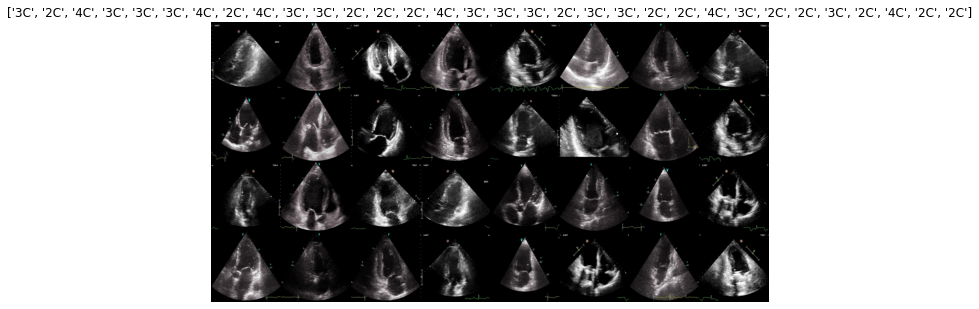

Num Images in train set: 6717
Num Images in test set: 1607
Num batch in train set:  210
class:  {'2C': 0, '3C': 1, '4C': 2}
image size:  torch.Size([3, 224, 224])
model: densnet121
device: cuda
---------------------------------------------------------------

Epoch 0 report: 
Epoch 0 step 39 ave_loss 1.1009
Epoch 0 step 79 ave_loss 0.9727
Epoch 0 step 119 ave_loss 0.4580
Epoch 0 step 159 ave_loss 0.5045
Epoch 0 step 199 ave_loss 0.2815
Test report: 
               precision    recall  f1-score   support

          2C       0.63      0.80      0.70       409
          3C       0.50      0.59      0.55       367
          4C       0.94      0.74      0.83       831

    accuracy                           0.72      1607
   macro avg       0.69      0.71      0.69      1607
weighted avg       0.76      0.72      0.73      1607

---------------------------------------------------------------

Epoch 1 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 step 39 ave_loss 0.1722
Epoch 1 step 79 ave_loss 0.0919
Epoch 1 step 119 ave_loss 0.0959
Epoch 1 step 159 ave_loss 0.0522
Epoch 1 step 199 ave_loss 0.0244
Test report: 
               precision    recall  f1-score   support

          2C       0.55      0.87      0.67       409
          3C       0.63      0.65      0.64       367
          4C       0.95      0.66      0.78       831

    accuracy                           0.71      1607
   macro avg       0.71      0.73      0.70      1607
weighted avg       0.78      0.71      0.72      1607

---------------------------------------------------------------

Epoch 2 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 39 ave_loss 0.0269
Epoch 2 step 79 ave_loss 0.0158
Epoch 2 step 119 ave_loss 0.0089
Epoch 2 step 159 ave_loss 0.0070
Epoch 2 step 199 ave_loss 0.0060
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.73      0.72       409
          3C       0.72      0.83      0.77       367
          4C       0.93      0.86      0.89       831

    accuracy                           0.82      1607
   macro avg       0.79      0.80      0.79      1607
weighted avg       0.82      0.82      0.82      1607

---------------------------------------------------------------

Epoch 3 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 39 ave_loss 0.0114
Epoch 3 step 79 ave_loss 0.0279
Epoch 3 step 119 ave_loss 0.0667
Epoch 3 step 159 ave_loss 0.0771
Epoch 3 step 199 ave_loss 0.0101
Test report: 
               precision    recall  f1-score   support

          2C       0.87      0.72      0.79       409
          3C       0.68      0.83      0.75       367
          4C       0.93      0.91      0.92       831

    accuracy                           0.84      1607
   macro avg       0.82      0.82      0.82      1607
weighted avg       0.85      0.84      0.84      1607

---------------------------------------------------------------

Epoch 4 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 39 ave_loss 0.0097
Epoch 4 step 79 ave_loss 0.0142
Epoch 4 step 119 ave_loss 0.0067
Epoch 4 step 159 ave_loss 0.0036
Epoch 4 step 199 ave_loss 0.0014
Test report: 
               precision    recall  f1-score   support

          2C       0.73      0.76      0.75       409
          3C       0.57      0.77      0.66       367
          4C       0.97      0.81      0.88       831

    accuracy                           0.79      1607
   macro avg       0.76      0.78      0.76      1607
weighted avg       0.82      0.79      0.80      1607

---------------------------------------------------------------

Epoch 5 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 39 ave_loss 0.0014
Epoch 5 step 79 ave_loss 0.0010
Epoch 5 step 119 ave_loss 0.0017
Epoch 5 step 159 ave_loss 0.0070
Epoch 5 step 199 ave_loss 0.0037
Test report: 
               precision    recall  f1-score   support

          2C       0.74      0.76      0.75       409
          3C       0.58      0.80      0.67       367
          4C       0.97      0.80      0.88       831

    accuracy                           0.79      1607
   macro avg       0.76      0.79      0.77      1607
weighted avg       0.82      0.79      0.80      1607

---------------------------------------------------------------

Epoch 6 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 39 ave_loss 0.0017
Epoch 6 step 79 ave_loss 0.0028
Epoch 6 step 119 ave_loss 0.0038
Epoch 6 step 159 ave_loss 0.0017
Epoch 6 step 199 ave_loss 0.0011
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.73      0.76       409
          3C       0.63      0.86      0.72       367
          4C       0.95      0.84      0.89       831

    accuracy                           0.81      1607
   macro avg       0.79      0.81      0.79      1607
weighted avg       0.84      0.81      0.82      1607

---------------------------------------------------------------

Epoch 7 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 39 ave_loss 0.0007
Epoch 7 step 79 ave_loss 0.0165
Epoch 7 step 119 ave_loss 0.0218
Epoch 7 step 159 ave_loss 0.0146
Epoch 7 step 199 ave_loss 0.0105
Test report: 
               precision    recall  f1-score   support

          2C       0.75      0.79      0.77       409
          3C       0.66      0.80      0.72       367
          4C       0.95      0.84      0.89       831

    accuracy                           0.82      1607
   macro avg       0.79      0.81      0.80      1607
weighted avg       0.83      0.82      0.82      1607

---------------------------------------------------------------

Epoch 8 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 step 39 ave_loss 0.0062
Epoch 8 step 79 ave_loss 0.0019
Epoch 8 step 119 ave_loss 0.0005
Epoch 8 step 159 ave_loss 0.0007
Epoch 8 step 199 ave_loss 0.0063
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.75      0.72       409
          3C       0.73      0.75      0.74       367
          4C       0.91      0.87      0.88       831

    accuracy                           0.81      1607
   macro avg       0.78      0.79      0.78      1607
weighted avg       0.81      0.81      0.81      1607

---------------------------------------------------------------

Epoch 9 report: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 step 39 ave_loss 0.0028
Epoch 9 step 79 ave_loss 0.0006
Epoch 9 step 119 ave_loss 0.0003
Epoch 9 step 159 ave_loss 0.0011
Epoch 9 step 199 ave_loss 0.0008
Test report: 
               precision    recall  f1-score   support

          2C       0.75      0.78      0.77       409
          3C       0.71      0.83      0.76       367
          4C       0.98      0.88      0.93       831

    accuracy                           0.84      1607
   macro avg       0.81      0.83      0.82      1607
weighted avg       0.86      0.84      0.85      1607



In [25]:
result_Densnet121 = main(model='densnet121')